In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Z_DIM = 1
G_HIDDEN = 1000
X_DIM = 1000
D_HIDDEN = 1000

step_size_G = 0.01
step_size_D = 0.01
ITER_NUM = 50000

GRADIENT_CLIP = 0.2
WEIGHT_CLIP = 0.25


In [3]:
def get_samples(random=True):
    if random:
        x0 = np.random.uniform(0, 1)
        freq = np.random.uniform(1.2, 1.5)
        mult = np.random.uniform(0.5, 0.8)
    else:
        x0 = 0
        freq = 0.2
        mult = 1
    signal = [mult * np.cos(x0+freq*i) for i in range(X_DIM)]
    return np.array(signal)

In [4]:
# activation functions and their derivatives

def ReLU(x):
    return np.maximum(x, 0.)

def dReLU(x):
    return ReLU(x)

def LeakyReLU(x, k=0.2):
    return np.where(x >= 0, x, x * k)

def dLeakyReLU(x, k=0.2):
    return np.where(x >= 0, 1., k)

def Tanh(x):
    return np.tanh(x)

def dTanh(x):
    return 1. - Tanh(x)**2

def Sigmoid(x):
    return 1. / (1. + np.exp(-x))

def dSigmoid(x):
    return Sigmoid(x) * (1. - Sigmoid(x))


In [5]:
# helper 
def weight_initializer(in_channels, out_channels):
    scale = np.sqrt(2. / (in_channels + out_channels))
    return np.random.uniform(-scale, scale, (in_channels, out_channels))

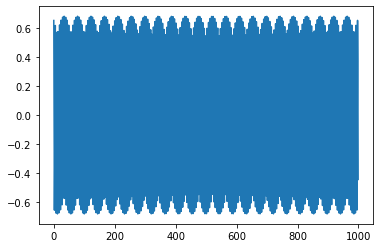

In [6]:
for i in range(1):
    samples = get_samples()
    plt.plot(samples)

In [7]:
# loss function
class LossFunc(object):
    def __init__(self):
        self.logit = None
        self.label = None
    
    def forward(self, logit, label):
        if logit[0,0] < 1e-7:
            logit[0,0] = 1e-7
        if 1 - logit[0,0] < 1e-7:
            logit[0,0] = 1 - 1e-7
        self.logit = logit
        self.label = label
        return -(label * np.log(logit) + (1 - label) * np.log(1 - logit))
    
    def backward(self):
        return (1-self.label) / (1-self.logit) - self.label / self.logit


In [8]:
# generator

class Generator(object):
    def __init__(self):
        self.z = None
        self.w1 = weight_initializer(Z_DIM, G_HIDDEN)
        self.b1 = weight_initializer(1, G_HIDDEN)
        self.x1 = None
        self.w2 = weight_initializer(G_HIDDEN, G_HIDDEN)
        self.b2 = weight_initializer(1, G_HIDDEN)
        self.x2 = None
        self.w3 = weight_initializer(G_HIDDEN, X_DIM)
        self.b3 = weight_initializer(1, X_DIM)
        self.x3 = None
        self.x = None
    
    def forward(self, inputs):
        self.z = inputs.reshape(1, Z_DIM)
        self.x1 = ReLU(np.matmul(self.z, self.w1) + self.b1)
        self.x2 = ReLU(np.matmul(self.x1, self.w2) + self.b2)
        self.x3 = np.matmul(self.x2, self.w3) + self.b3
        self.x = Tanh(self.x3)
        return self.x
    
    def backward(self, outputs):
        delta = outputs
        delta = delta * dTanh(self.x)
        d_w3 = np.matmul(np.transpose(self.x2), delta)
        d_b3 = delta.copy()
        delta = np.matmul(delta, np.transpose(self.w3))
        if (np.linalg.norm(d_w3) > GRADIENT_CLIP):
            d_w3 = GRADIENT_CLIP / np.linalg.norm(d_w3) * d_w3
        self.w3 -= step_size_G * d_w3
        self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
        self.b3 -= step_size_G * d_b3
        self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b3))
        delta *= dReLU(self.x2)
        d_w2 = np.matmul(np.transpose(self.x1), delta)
        d_b2 = delta.copy()
        delta = np.matmul(delta, np.transpose(self.w2))
        if (np.linalg.norm(d_w2) > GRADIENT_CLIP):
            d_w2 = GRADIENT_CLIP / np.linalg.norm(d_w2) * d_w2
        self.w2 -= step_size_G * d_w2
        self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w2))
        self.b2 -= step_size_G * d_b2
        self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b2))
        delta *= dReLU(self.x1)
        d_w1 = np.matmul(np.transpose(self.z), delta)
        d_b1 = delta.copy()
        if (np.linalg.norm(d_w1) > GRADIENT_CLIP):
            d_w1 = GRADIENT_CLIP / np.linalg.norm(d_w1) * d_w1
        self.w1 -= step_size_G * d_w1
        self.w1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w1))
        

In [9]:
class Discriminator(object):
    def __init__(self):
        self.x = None
        self.w1 = weight_initializer(X_DIM, D_HIDDEN)
        self.b1 = weight_initializer(1, D_HIDDEN)
        self.y1 = None
        self.w2 = weight_initializer(D_HIDDEN, D_HIDDEN)
        self.b2 = weight_initializer(1, D_HIDDEN)
        self.y2 = None
        self.w3 = weight_initializer(D_HIDDEN, 1)
        self.b3 = weight_initializer(1, 1)
        self.y3 = None
        self.y = None
        
    def forward(self, inputs):
        self.x = inputs.reshape(1, X_DIM)
        self.y1 = np.matmul(self.x, self.w1) + self.b1
        self.y1 = LeakyReLU(self.y1)
        self.y2 = np.matmul(self.y1, self.w2) + self.b2
        self.y2 = LeakyReLU(self.y2)
        self.y3 = np.matmul(self.y2, self.w3) + self.b3
        self.y = Sigmoid(self.y3)
        return self.y
    
    def backward(self, outputs, apply_grads=True):
        delta = outputs
        delta *= dSigmoid(self.y)
        d_w3 = np.matmul(np.transpose(self.y2), delta)
        d_b3 = delta.copy()
        delta = np.matmul(delta, np.transpose(self.w3))
        if apply_grads:
            if np.linalg.norm(d_w3) > GRADIENT_CLIP:
                d_w3 = GRADIENT_CLIP / np.linalg.norm(d_w3) * d_w3
            self.w3 += step_size_D * d_w3
            self.w3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.w3))
            self.b3 += step_size_D * d_b3
            self.b3 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, self.b3))
        delta *= dLeakyReLU(self.y2)
        d_w2 = np.matmul(np.transpose(self.y1), delta)
        d_b2 = delta.copy()
        delta = np.matmul(delta, np.transpose(self.w2))
        if apply_grads:
            if np.linalg.norm(d_w2) > GRADIENT_CLIP:
                d_w2 = GRADIENT_CLIP / np.linalg.norm(d_w2) * d_w2
            self.w2 +=  step_size_D * d_w2
            self.w2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, step_size_D * d_w2))
            self.b2 += step_size_D * d_b2
            self.b2 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, step_size_D * d_b2))
        delta *= dLeakyReLU(self.y1)
        d_w1 = np.matmul(np.transpose(self.x), delta)
        d_b1 = delta.copy()
        delta = np.matmul(delta, np.transpose(self.w1))
        if apply_grads:
            if np.linalg.norm(d_w1) > GRADIENT_CLIP:
                d_w1 = GRADIENT_CLIP / np.linalg.norm(d_w1) * d_w1
            self.w1 += step_size_D * d_w1
            self.w1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, step_size_D * d_w1))
            self.b1 += step_size_D * d_b1
            self.b1 = np.maximum(-WEIGHT_CLIP, np.minimum(WEIGHT_CLIP, step_size_D * d_b1))
        return delta
        

In [10]:
G = Generator()
D = Discriminator()
criterion = LossFunc()

real_label = 1
fake_label = 0

for itr in range(ITER_NUM):
    x_real = get_samples(True)
    y_real = D.forward(x_real)
    loss_D_r = criterion.forward(y_real, real_label)
    d_loss_D = criterion.backward()
    D.backward(d_loss_D)
    
    z_noise = np.random.randn(Z_DIM)
    x_fake = G.forward(z_noise)
    y_fake = D.forward(x_fake)
    loss_D_f = criterion.forward(y_fake, fake_label)
    d_loss_D = criterion.backward()
    D.backward(d_loss_D)
    
    y_fake_r = D.forward(x_fake)
    loss_G = criterion.forward(y_fake_r, real_label)
    d_loss_G = D.backward(loss_G, apply_grads=False)
    G.backward(d_loss_G)
    loss_D = loss_D_r + loss_D_f
    if itr % 100 == 0:
        print('{} {} {}'.format(loss_D_r.item((0, 0)), loss_D_f.item((0, 0)), loss_G.item((0, 0))))
    

1.003208264512905 0.575286462528848 0.19620582912364068
0.823247858769062 0.5756291970102836 0.19620576842775508
0.8232484285321556 0.5756297673684624 0.19620591482012048
0.823248997248612 0.5756303366792151 0.19620606094357082
0.8232495649203494 0.5756309049444605 0.19620620679859918
0.8232501315492833 0.5756314721661147 0.1962063523856976
0.8232506971373257 0.5756320383460892 0.19620649770535728
0.8232512616863844 0.575632603486293 0.19620664275806854
0.8232518251983649 0.5756331675886313 0.19620678754432072
0.823252387675168 0.5756337306550056 0.19620693206460235
0.8232529491186918 0.5756342926873141 0.196207076319401
0.8232535095308305 0.5756348536874519 0.1962072203092036
0.8232540689134754 0.5756354136573099 0.19620736403449568
0.8232546272685137 0.5756359725987761 0.19620750749576235
0.8232551845978294 0.5756365305137349 0.19620765069348764
0.8232557409033033 0.575637087404067 0.19620779362815466
0.8232562961868125 0.5756376432716505 0.19620793630024588
0.8232568504502308 0.5756

In [ ]:
x_axis = np.linspace(0, 10000, 100)
for i in range(50):
    z_noise = np.random.randn(Z_DIM)
    x_fake = G.forward(z_noise)
    plt.plot(x_axis, x_fake.reshape(X_DIM))
plt.ylim((-1,1))
plt.show()